In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
figsize(12.5, 4)

In [3]:
import numpy as np
import scipy.stats as stats

In [4]:
colors = ["#348ABD", "#A60628"]

#### 不同lambda取值下泊松分布的概率质量函数

Text(0.5, 1.0, 'Probability mass function of a poisson random variable,        differing \\$\\lambda$ values')

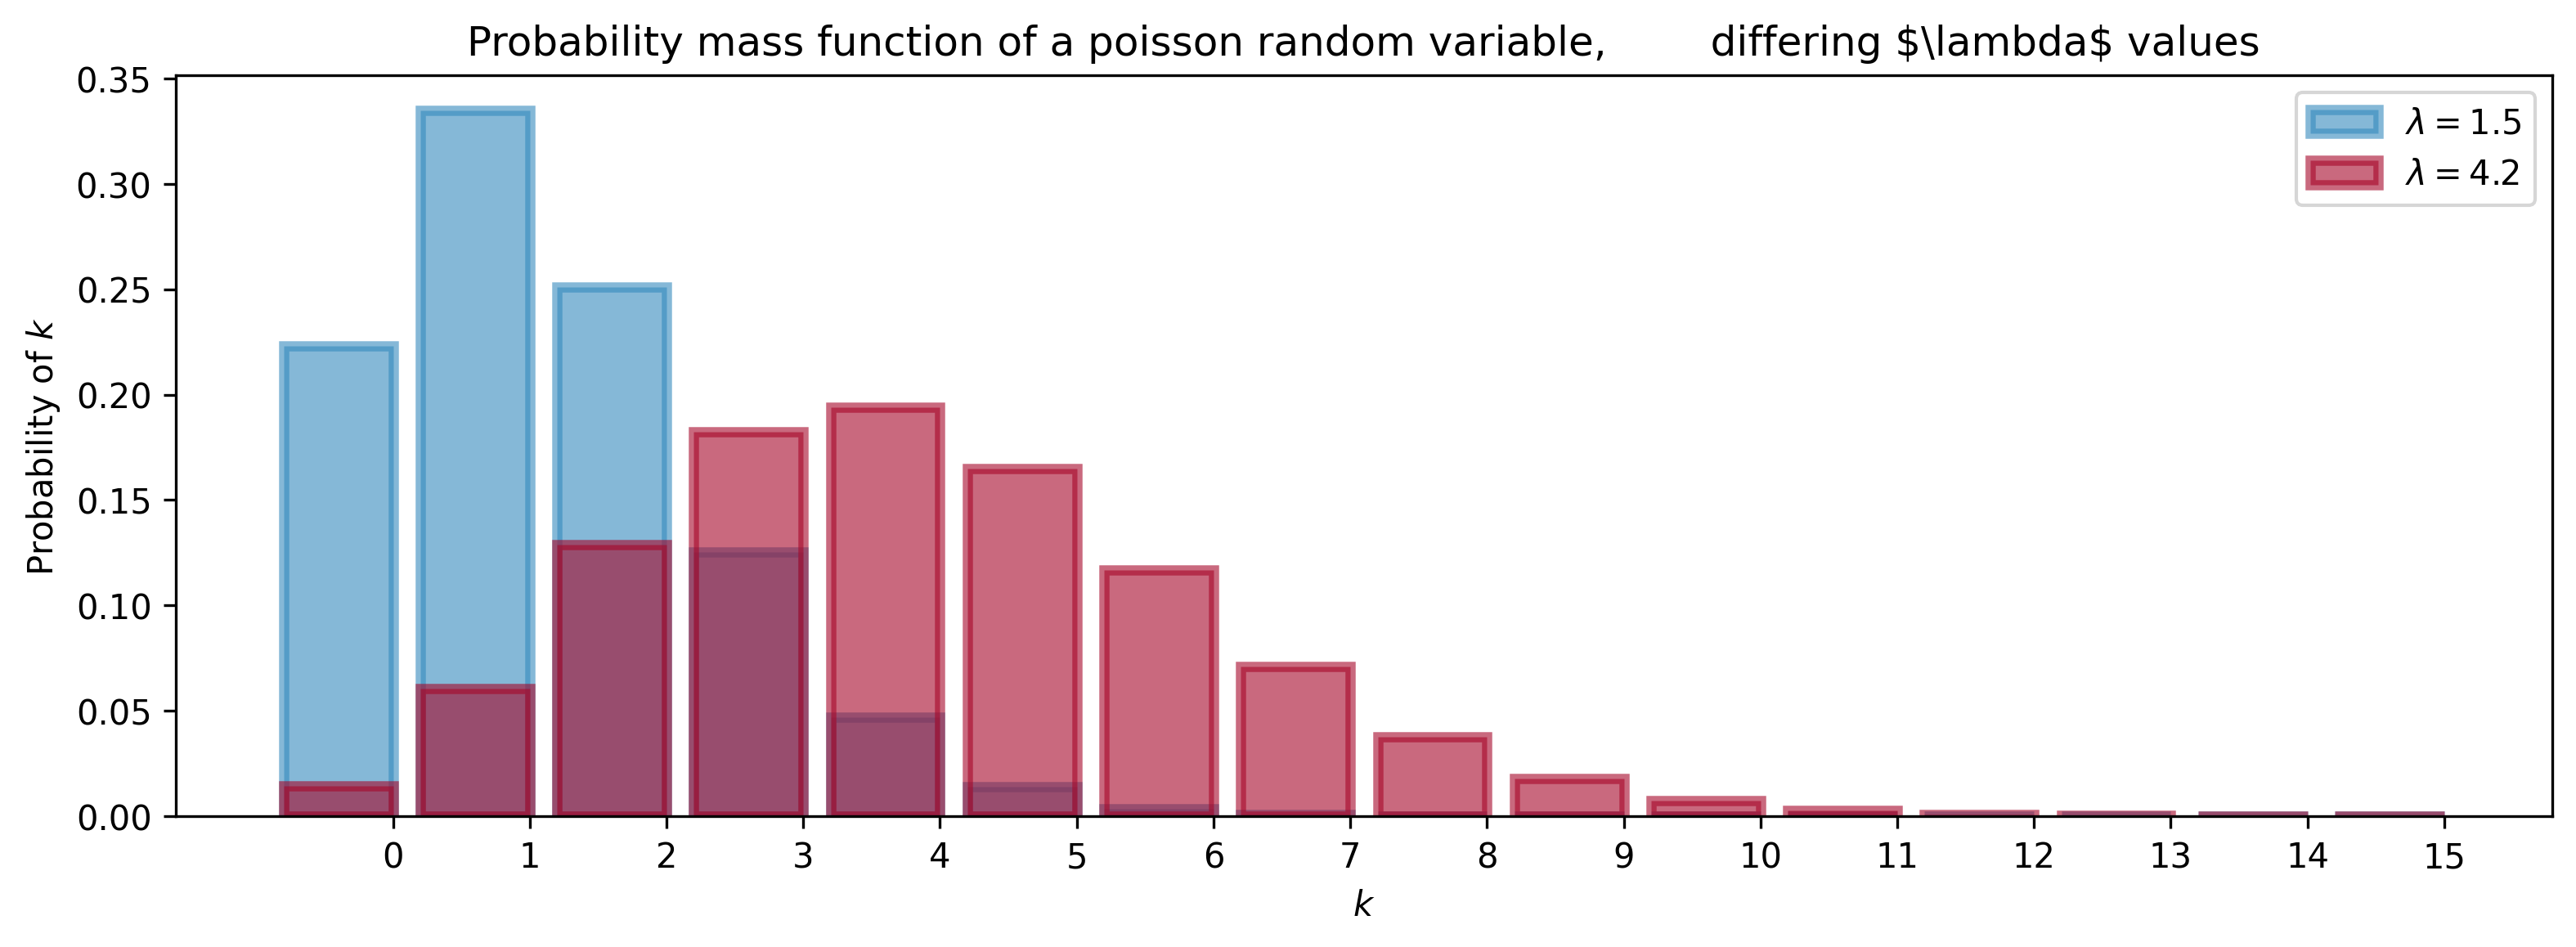

In [5]:
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
                  label="$\lambda = %.1f$" % lambda_[0], alpha=0.60,
                  edgecolor=colors[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
                  label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
                  edgecolor=colors[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("Probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a poisson random variable,\
        differing \$\lambda$ values")

#### 不同lambda取值下指数分布的概率密度函数

In [6]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1./l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0,1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

#### 加载待分析的短信息数据

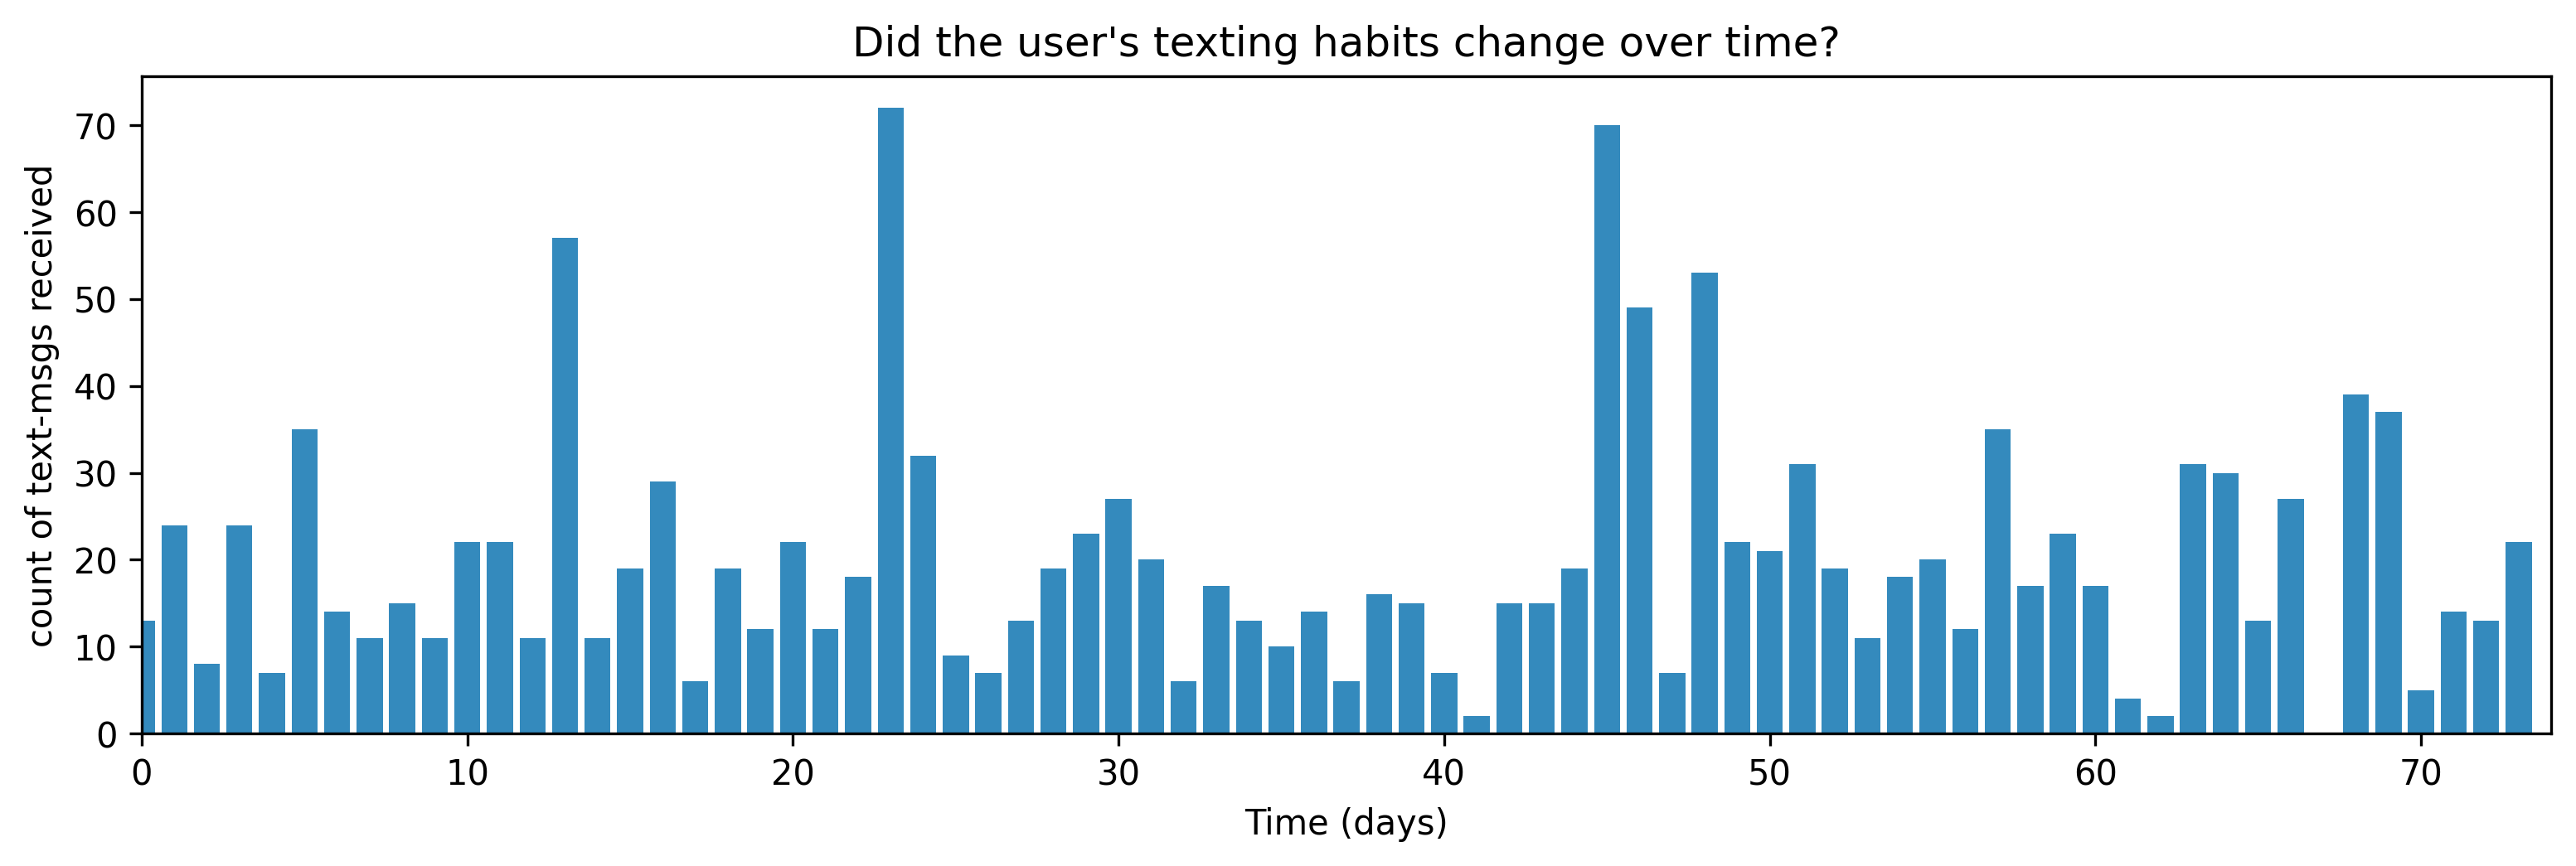

In [6]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

#### 用PyMC3分析短信行为

In [7]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [8]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [9]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [10]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

/opt/anaconda3/envs/pytorch/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

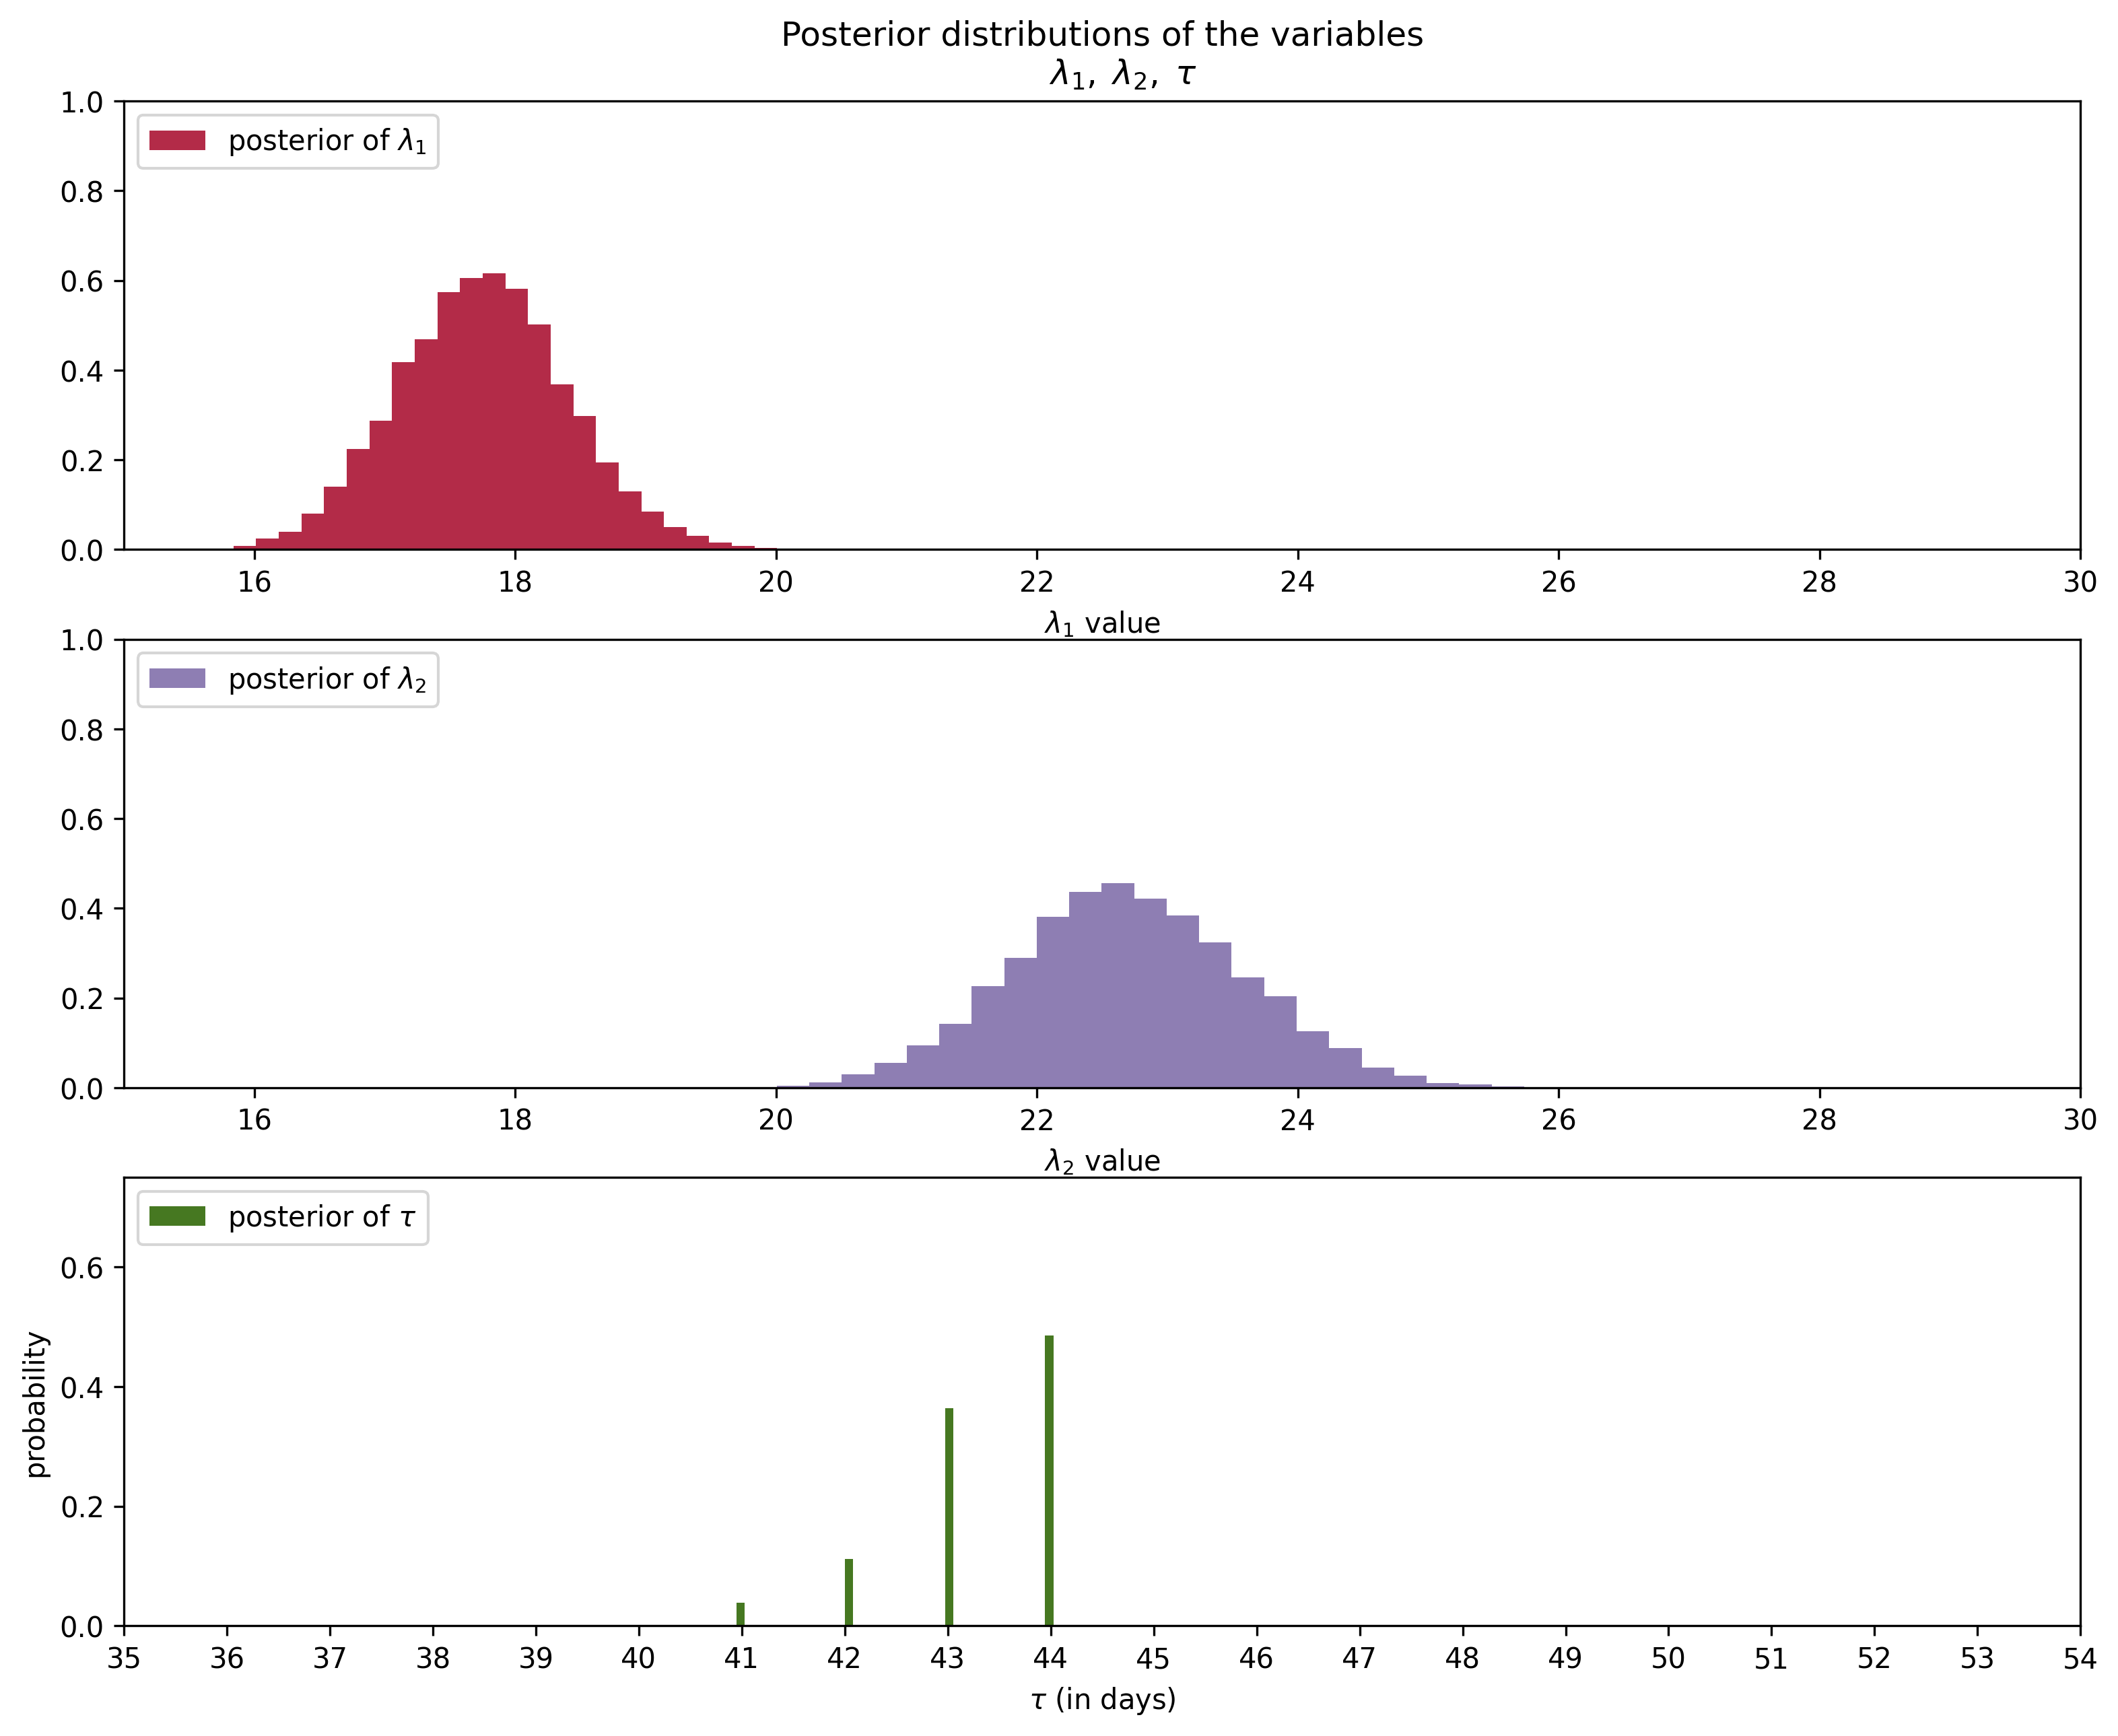

In [13]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

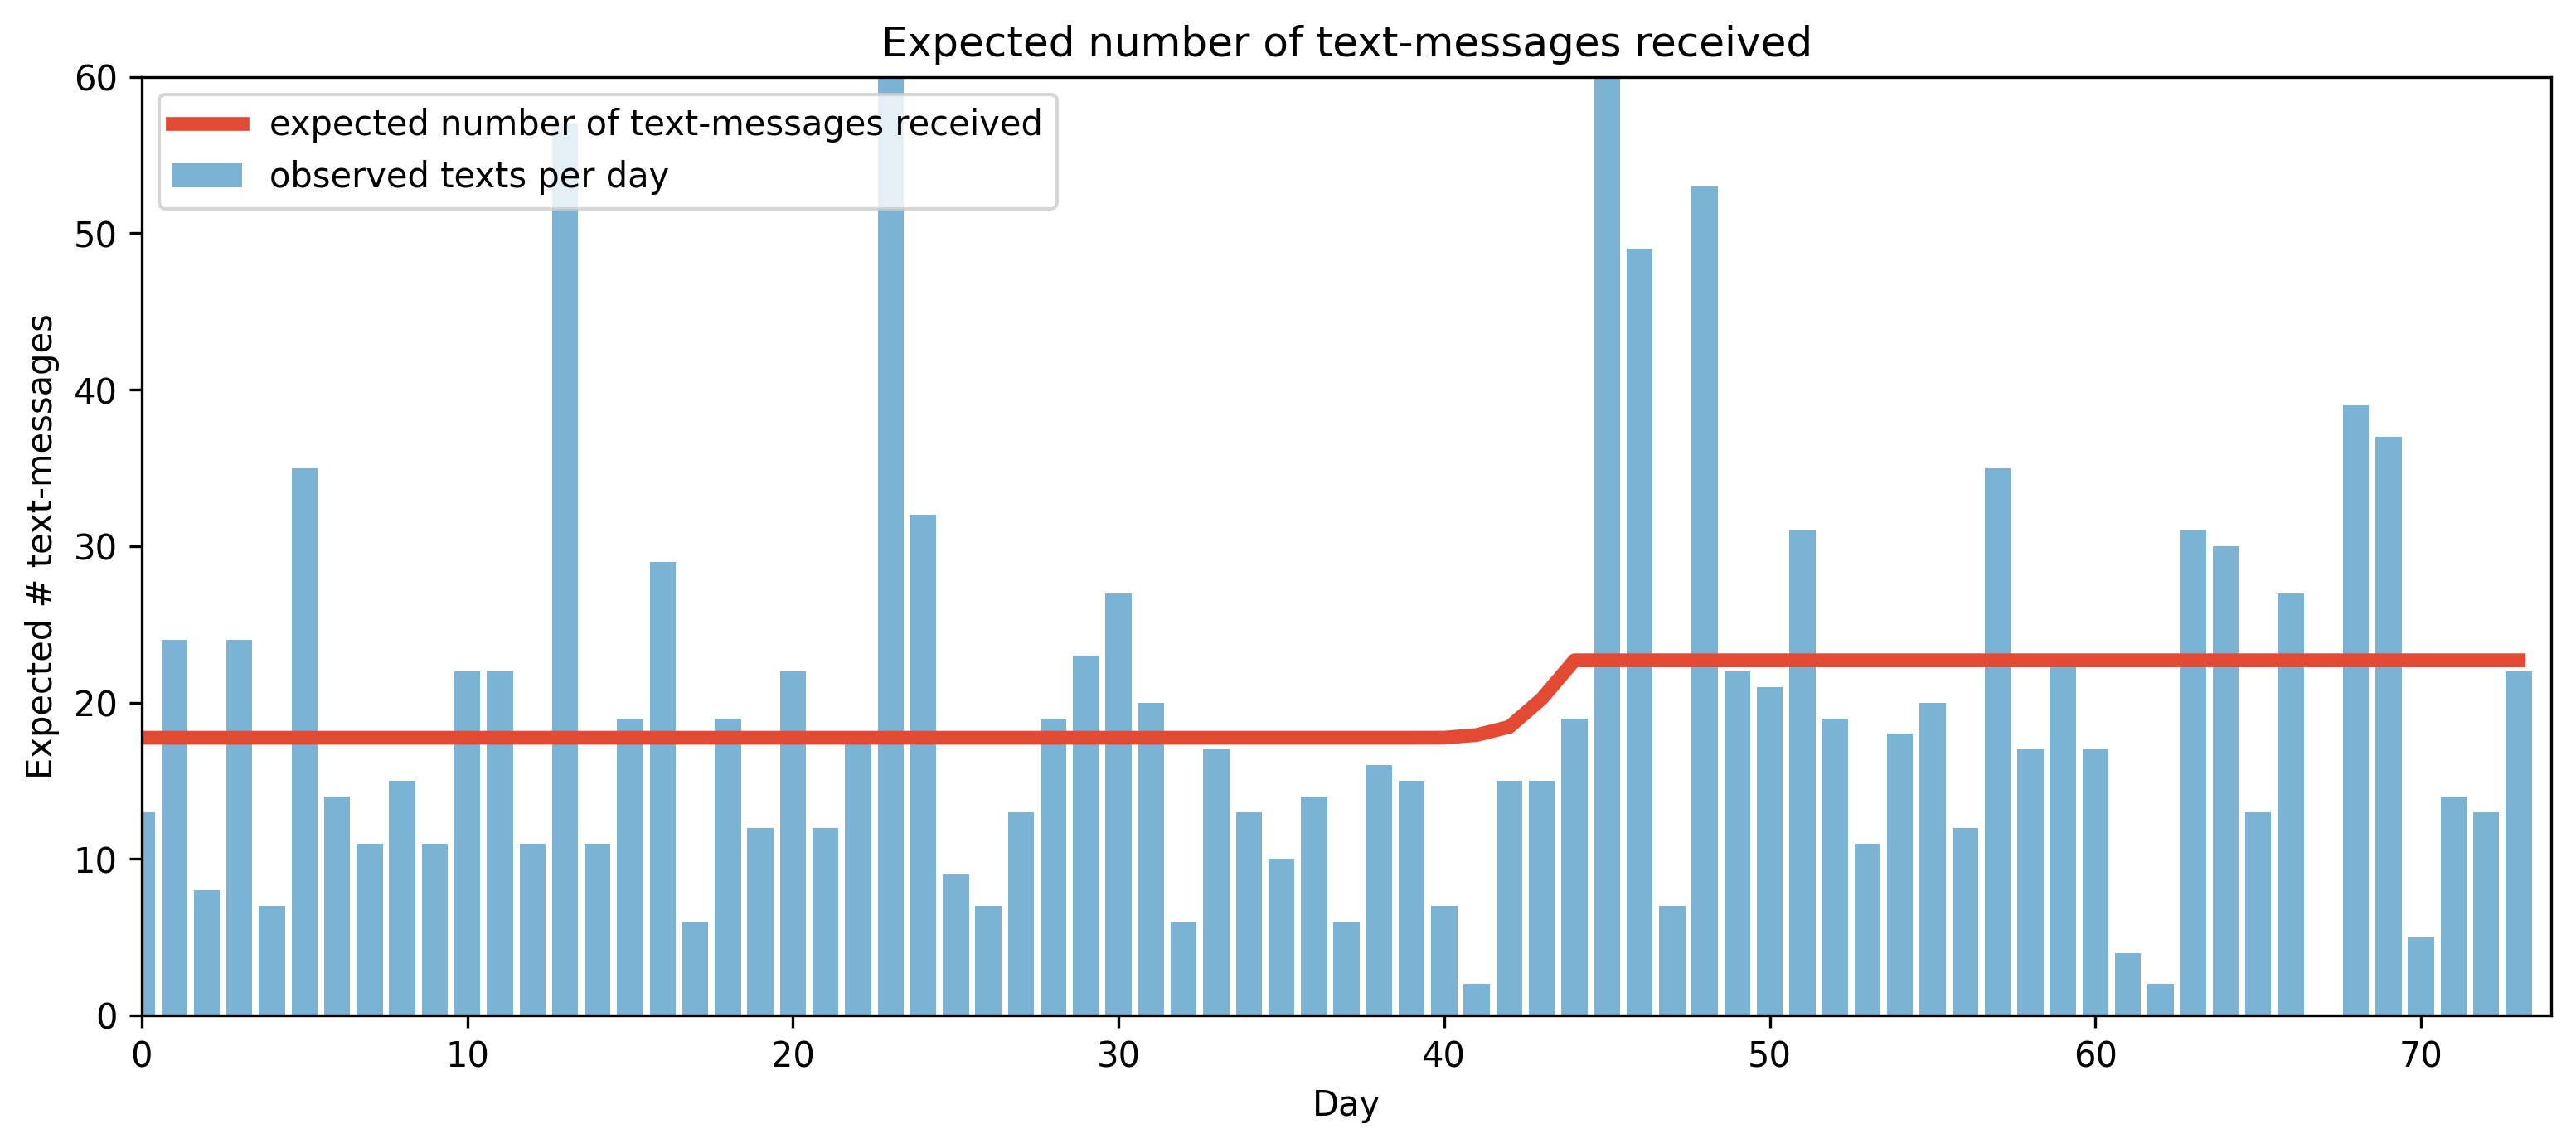

In [14]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");